# [SSC] Creating a function to extract the slip and slip rate at a location along the fault for se2dr: Sigmoid implementation
by JN Hayek (Created on 04.12.2020)

***
The idea here is to locate receivers along the fault and extract slip and slip rate from the positive and negative sides of the fault

The approach is similar to what was done in the SDF sigmoid implementation:

* Use a function that defines the zero level set function.
* Use the respective derivative of the zero level set function.
    - This means that we are able to calculate the signed distance function, the normal, and the tangent
* It is needed to calculate the distance along the fault, and find the location along the fault of interest
* Use the normal to move into positive and negative side and find the receiver pair (DistOnFault, Thickness) -> cartesian coordinates (x,y)
* Use the tangential direction vector at the point of interest to get the tangential displacement and velocity at each receiver pair.
* Substract the two pairs components to get slip and slip rate

***

**Input:**
- Function, derivative of Function
- List of points (Loc Along the Fault, Thickness)
- Fields (Displacement X,Y, Velocity X,Y)


- Sampling frequency
- Total number of Timesteps


- Geometry function parameters


- Path to fields
- Path to output

Output File Naming:
- Cell dimensions
- p-refinement
- delta value

***
**Intended Output**

Pickle file containing:
- Coordinates in cartesian and relative to the fault for readability (This is for you, future me ;))
    - Coordinates on the fault, at te interface and twin
- Slip and slip rate along the fault (Parallel and perpendicular component)
- Time evolution

# Import libraries

In [1]:
import os, sys, time
import numpy as np
from scipy.interpolate import RectBivariateSpline
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pylab as plt

from se2waveload import *

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *


# Function definitions

In [159]:
# Sigmoid or any function of interest to represent the center of the fault / Zero level set function
def func(x, k=-0.0002, amp = 2.0):
    fx = amp * (x - x * k) / (k - abs(x) * 2.0 * k + 1.0)
    return fx

# The respective derivative ofthe previous zero level set function
def func_der(x, k=-0.0002, amp = 2.0):
    fx_prime = amp * (1 - k * k) / ((k - abs(x) * 2.0 * k + 1.0)*(k - abs(x) * 2.0 * k + 1.0))
    return fx_prime


# Tangent vector for a given derivative
def TangentVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    TangentX = 1.0/mag
    TangentY = fPrimeX/mag
    return TangentX, TangentY

# Normal vector for a given derivative
def NormalVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    NormalX = -fPrimeX/mag
    NormalY = 1.0/mag
    
    return NormalX, NormalY



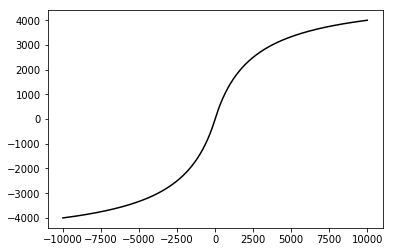

In [3]:
#Test
plt.figure()
xx = np.linspace(-1.e4, 1.e4, 6001)
plt.plot(xx,func(xx),"k-")

 For checking up, the index that defines the 0-distance along the fault is 3000

In [4]:
xx[3000]

0.0

## Functions extracted from Lib_ProfileProcessing
Broken apart for reuse in the case of the sigmoid function

In [268]:
def SeparateList(List2Sep,nx,ny):
    TotNum = len(List2Sep)
    xComponent = List2Sep[0:TotNum:2]
    yComponent = List2Sep[1:TotNum:2]

    xComponent = np.reshape(xComponent, (nx, ny), "F")
    yComponent = np.reshape(yComponent, (nx, ny), "F")
    return xComponent,yComponent


def ExtractFields(w_filename, se2_coor):
    se2_field = se2wave_load_wavefield(w_filename,True,True)
    TimeStep = se2_field["time"].item()

    LCoorX, LCoorY         = SeparateList(se2_coor['coor'],   se2_coor['nx'].item(),  se2_coor['ny'].item())
    LFieldX, LFieldY       = SeparateList(se2_field['displ'], se2_field['nx'].item(), se2_field['ny'].item())
    LFieldvelX, LFieldvelY = SeparateList(se2_field['vel'],   se2_field['nx'].item(), se2_field['ny'].item())
    
    return TimeStep, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY


def GetBivariateSplineFuncFromFields(LCoorX, LCoorY, LFieldX, LFieldY,LFieldvelX, LFieldvelY):
    SplineDispl = [RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldX, kx=1, ky=1), 
                   RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldY, kx=1, ky=1)]
    SplineVel = [RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldvelX, kx=1, ky=1), 
                 RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldvelY, kx=1, ky=1)]
    
    return SplineDispl, SplineVel


def GetLocData(Loc, SplineFunction, GetSlip=False):

    CompX = SplineFunction[0](Loc[0],Loc[1])[0][0]
    CompY = SplineFunction[1](Loc[0],Loc[1])[0][0]
    return CompX, CompY


# Wrappers
def GetSplineFunctions(w_filename, se2_coor):
    TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(w_filename, se2_coor)
    SplineDisplPair, SplineVelPair = GetBivariateSplineFuncFromFields(LCoorX, LCoorY, 
                                                              LFieldX, LFieldY,
                                                              LFieldvelX, LFieldvelY)
    return TimeStepVal, SplineDisplPair, SplineVelPair

In [30]:
def PlotDomain(CoorX, CoorY, Field, FieldName,TimeTxt):
    try:
      fig = plt.figure(figsize = (10, 10), constrained_layout=True)
      gs = fig.add_gridspec(1, 1)
      ax = fig.add_subplot(gs[:, :])
    except:
      fig = plt.figure(figsize = (10, 10))
      ax = fig.add_subplot(1,1,1)
    ax.set_title("{FName}".format(FName = FieldName[0]))
    ax.set_xlabel("X-Coordinate [m]"), ax.set_ylabel("Y-Coordinate [m]")
    ax.set_aspect('equal', 'box')
    img = ax.pcolormesh(CoorX, CoorY, Field)

    ax.annotate(text=TimeTxt,xy=[0.8,0.1], xycoords= "axes fraction")
    cbar = fig.colorbar(img, shrink=.5)
    cbar.ax.set_ylabel(FieldName[1])
    
    return fig, img

In [7]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/se2wave/"


i=1131
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

In [8]:
TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.collections.QuadMesh at 0x1466304fbef0>)

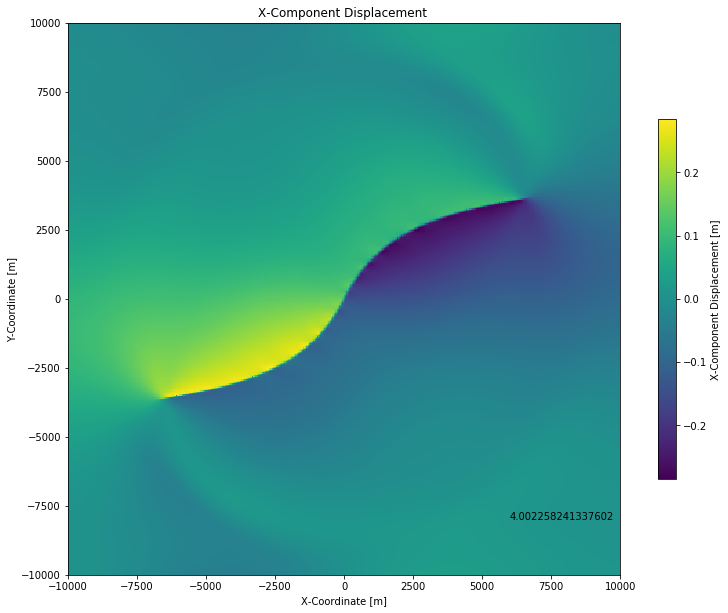

In [31]:
PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal)


In [10]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6993043422698975 seconds ---


In [11]:
from sklearn.metrics.pairwise import euclidean_distances


def GetListCoords_FaultGeometry(xx):
    return list(map(list,zip(xx,func(xx))))

def GetClosestIndex(Coordx, Coordy, FaultNodes_CoordList):
    IndexMin = np.argmin(euclidean_distances(FaultNodes_CoordList,[[Coordx,Coordy]]))
    return IndexMin
    
def CreateMeshGrid(Nx,Ny):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    
    xv, yv = np.meshgrid(x, y)
    return xv, yv




In [12]:
FaultNodes_CoordList = GetListCoords_FaultGeometry(xx)

Nx = len(LCoorX[:,0]); Ny = len(LCoorX[0,:]);

GetClosestIndex(LCoorX[0,0], LCoorY[0,0], FaultNodes_CoordList)

0

In [13]:
z = np.array([[GetClosestIndex(LCoorX[j,i], LCoorY[j,i], FaultNodes_CoordList) for i in range(Nx)] for j in range(Ny)])
print("--- %s seconds ---" % (time.time() - start_time))

--- 261.0697205066681 seconds ---


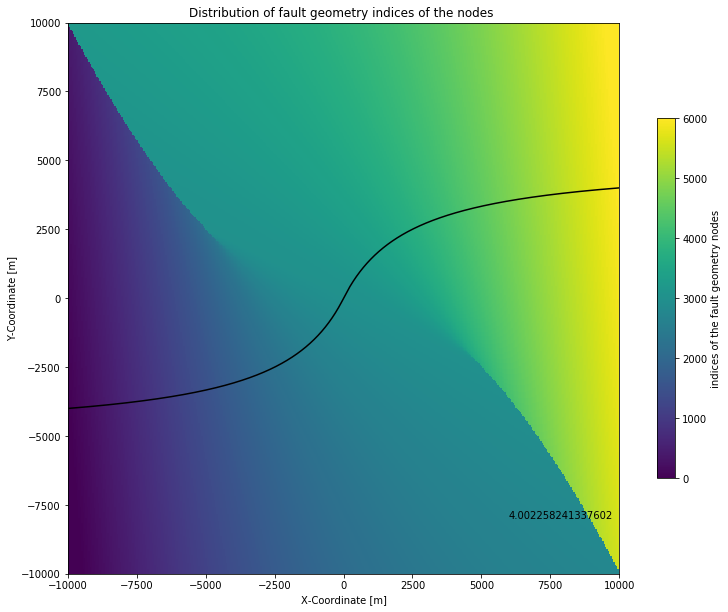

In [58]:
PlotDomain(LCoorX, LCoorY, np.array(z), 
           ["Distribution of fault geometry indices of the nodes ","indices of the fault geometry nodes"],
           TimeStepVal)
plt.plot(xx,func(xx),"k-")

In [15]:
def CumulativeDistOnFault(idx:int, xArray, centerIdx:int):
    Distance = 0.0
    if (idx > centerIdx):
        for i in range(centerIdx,idx):
            Distance += euclidean_distances([[xArray[i+1],func(xArray[i+1])]],
                                            [[xArray[i],func(xArray[i])]]
                                           )[0][0]
        
    elif (idx < centerIdx):
        for i in range(idx,centerIdx):
            Distance += euclidean_distances([[xArray[i+1],func(xArray[i+1])]],
                                            [[xArray[i],func(xArray[i])]]
                                           )[0][0]
    return Distance

In [16]:
CumulativeDistArray = np.array(list(map((lambda idx : CumulativeDistOnFault(idx, xx, centerIdx = 3000)), range(xx.shape[0]))))

In [17]:
DistField = np.array(list(map(lambda x : list(map(lambda y: CumulativeDistArray[y], x)) , z)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 944.3786540031433 seconds ---


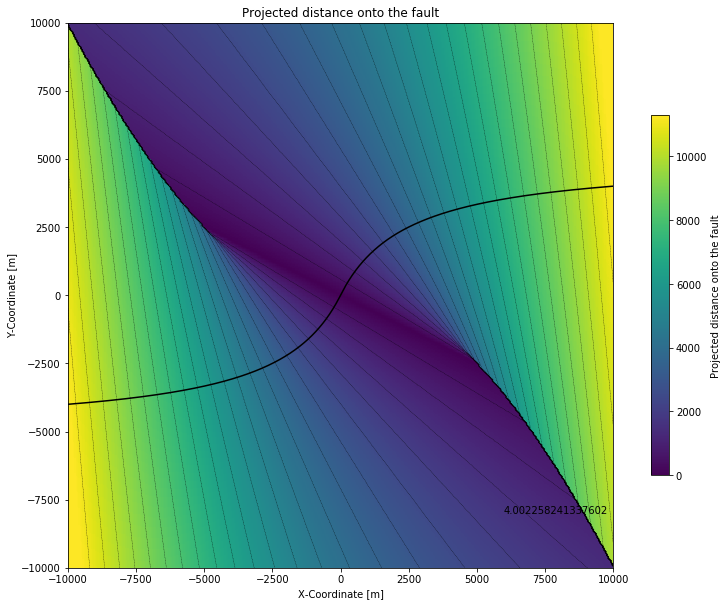

In [59]:
PlotDomain(LCoorX, LCoorY, DistField, 
           ["Projected distance onto the fault","Projected distance onto the fault"]
           ,TimeStepVal)
plt.plot(xx,func(xx),"k-")
plt.contour(LCoorX,LCoorY,DistField,levels=np.arange(-1.5e4, 1.5e4, 500), colors="k",linestyles="--",linewidths=0.3)

In [19]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 945.1609876155853 seconds ---


In [20]:
DistMaskedOut = np.ma.masked_greater(DistField,500)

In [21]:
def get_SDF(xCoord,yCoord,idx,xArray):
    return euclidean_distances([[xCoord,yCoord]],[[xArray[idx],func(xArray[idx])]])[0][0]

In [22]:
SDF_Matrix = np.array([[get_SDF(LCoorX[j,i], LCoorY[j,i],z[j,i],xx) for i in range(Nx)] for j in range(Ny)])
print("--- %s seconds ---" % (time.time() - start_time))

--- 957.4485068321228 seconds ---


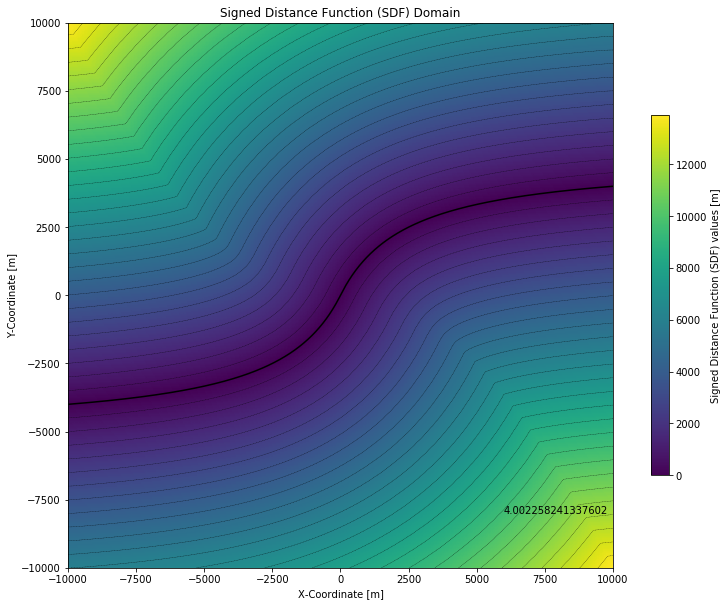

In [61]:
PlotDomain(LCoorX, LCoorY, SDF_Matrix, 
           ["Signed Distance Function (SDF) Domain","Signed Distance Function (SDF) values [m]"],
           TimeStepVal)
plt.plot(xx,func(xx),"k-")
plt.contour(LCoorX,LCoorY,SDF_Matrix,levels=np.arange(-1.5e4, 1.5e4, 500), colors="k",linestyles="--",linewidths=0.3)

In [24]:
DistSDFMaskedOut = np.ma.masked_where(SDF_Matrix > 1000, DistField) 
OnlyDistMaskedOut = np.ma.masked_where(SDF_Matrix > 1000, SDF_Matrix) 

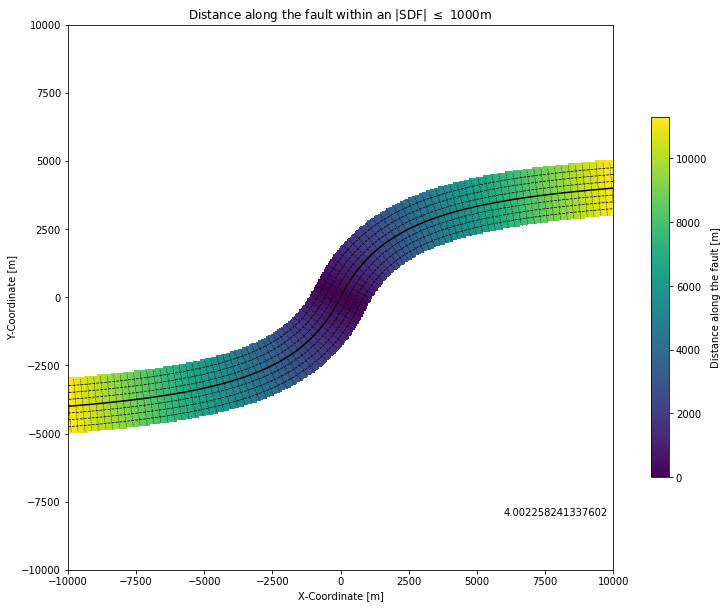

In [56]:
PlotDomain(LCoorX, LCoorY, DistSDFMaskedOut, 
           ["Distance along the fault within an |SDF| $\leq$ 1000m", "Distance along the fault [m]"],
           TimeStepVal)
plt.plot(xx,func(xx),"k-")
plt.contour(LCoorX,LCoorY,DistSDFMaskedOut,levels=np.arange(-1.5e4, 1.5e4, 250), colors="k",linestyles="--",linewidths=0.4)
plt.contour(LCoorX,LCoorY,OnlyDistMaskedOut,levels=np.arange(-1.e3, 1.e3, 250), colors="k",linestyles="--",linewidths=0.75)

### Now we want to find the cartesian coordinates of a point at a distance of 2, 4, 6, 8000m along the fault 

In [160]:
def FindDistIndx(DistOfInterest, xArray, centerIdx:int):
    Distance = 0.0
    for i in range(centerIdx,len(xArray)):
        Distance += euclidean_distances([[xArray[i+1],func(xArray[i+1])]],
                                        [[xArray[i],func(xArray[i])]]
                                        )[0][0]
        if(Distance>DistOfInterest):
            break
    return i
        

In [197]:
LocOfInterest = [2000,4000,6000,8000]
Thickness = 500
idx_Interest = [FindDistIndx(DistOfInterest = a, xArray = xx, centerIdx = 3000)for a in LocOfInterest]

NewXCoordinates = xx[idx_Interest]
NewYCoordinates = func(xx[idx_Interest])

for idx,i in enumerate(idx_Interest):
    NewXCoordinates[idx] = NewXCoordinates[idx] + (np.array(NormalVector(func_der(xx[i])))*Thickness)[0]
    NewYCoordinates[idx] = NewYCoordinates[idx] + (np.array(NormalVector(func_der(xx[i])))*Thickness)[1]
    
NewXCoordinatesTwin = xx[idx_Interest]
NewYCoordinatesTwin = func(xx[idx_Interest])

for idx,i in enumerate(idx_Interest):
    NewXCoordinatesTwin[idx] = NewXCoordinatesTwin[idx] + (-np.array(NormalVector(func_der(xx[i])))*Thickness)[0]
    NewYCoordinatesTwin[idx] = NewYCoordinatesTwin[idx] + (-np.array(NormalVector(func_der(xx[i])))*Thickness)[1]


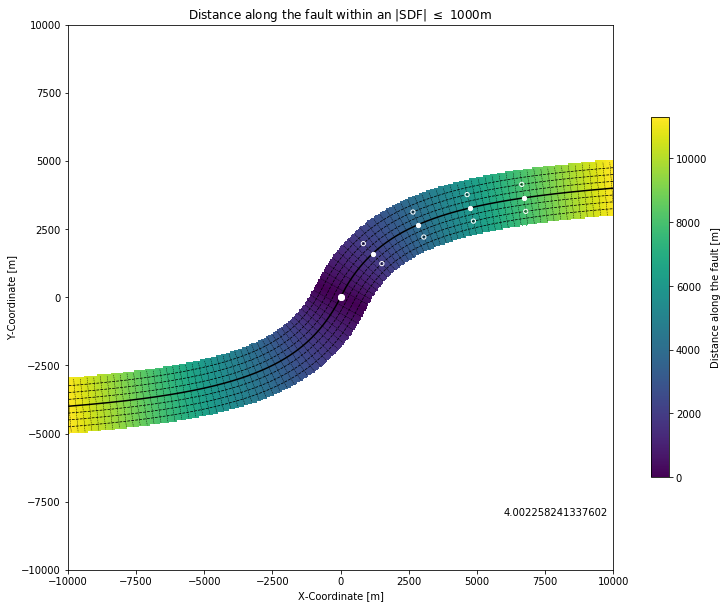

In [198]:
PlotDomain(LCoorX, LCoorY, DistSDFMaskedOut, 
           ["Distance along the fault within an |SDF| $\leq$ 1000m", "Distance along the fault [m]"],
           TimeStepVal)
plt.plot(xx,func(xx),"k-")
plt.contour(LCoorX,LCoorY,DistSDFMaskedOut,levels=np.arange(-1.5e4, 1.5e4, 250), colors="k", linestyles="--",linewidths=0.4)
plt.contour(LCoorX,LCoorY,OnlyDistMaskedOut,levels=np.arange(-1.e3, 1.e3, 250), colors="k", linestyles="--",linewidths=0.75)


MarkerSpecs = {"marker":".","c":"w","s":72,"zorder":9}
plt.scatter(0, 0, c="w", zorder=9)
plt.scatter(xx[idx_Interest],func(xx[idx_Interest]), **MarkerSpecs)

MarkerSpecs = {"marker":".","facecolors":"none","edgecolors":"w","s":72,"zorder":9}
plt.scatter(0, 0, c="w", zorder=9)
plt.scatter(NewXCoordinates,NewYCoordinates, **MarkerSpecs)
plt.scatter(NewXCoordinatesTwin,NewYCoordinatesTwin, **MarkerSpecs)

In [249]:
class FaultData:
    def __init__(self, LocOfInterest, HalfThickness, Xval, Fxval, FxPrimeVal):
        self.DistAlongFault = LocOfInterest
        self.HalfThickness = HalfThickness
        self.Xval = Xval
        self.Fxval = Fxval
        self.FxPrimeVal = FxPrimeVal
        
        self.Normal = np.array(NormalVector(self.FxPrimeVal))
        self.Tangent = np.array(TangentVector(self.FxPrimeVal))
        
        self.RecSide1X = self.Xval + (np.array(NormalVector(self.FxPrimeVal))*Thickness)[0]
        self.RecSide1Y = self.Fxval + (np.array(NormalVector(self.FxPrimeVal))*Thickness)[1]
        self.RecSide2X = self.Xval - (np.array(NormalVector(self.FxPrimeVal))*Thickness)[0]
        self.RecSide2Y = self.Fxval - (np.array(NormalVector(self.FxPrimeVal))*Thickness)[1]
        
        
        self.Time = []
        self.Slip = []
        self.SlipRate = []
        
    def __repr__(self):
        return "FaultData Object, distance {} - half thickness {}".format(self.DistAlongFault, self.HalfThickness)
    
    def __str__(self):
        return "Fault Data at distance {}, half thickness {}".format(self.DistAlongFault, self.HalfThickness)
    
    def GetReceiverCoords(self):
        return [self.RecSide1X, self.RecSide1Y]
    
    def GetTwinReceiverCoords(self):
        return [self.RecSide2X, self.RecSide2Y]
    
    def appendFaultValues(self, time, Slip, SlipRate):
        self.Time.append(time)
        self.Slip.append(Slip)
        self.SlipRate.append(SlipRate)
        
    def ExtractTangentFieldComponentDiff(self, SplineFunctionPair):
        SetCoords1 = [self.RecSide1X, self.RecSide1Y]
        SetCoords2 = [self.RecSide2X, self.RecSide2Y]
        
        Comp1X, Comp1Y = GetLocData(SetCoords1, SplineFunctionPair)
        Comp2X, Comp2Y = GetLocData(SetCoords2, SplineFunctionPair)
        
        TanDisp1 = self.Tangent[0]*Comp1X + self.Tangent[1]*Comp1Y 
        TanDisp2 = self.Tangent[0]*Comp2X + self.Tangent[1]*Comp2Y 
        
        return TanDisp1 - TanDisp2
        
    
    # Tangent vector for a given derivative
    def TangentVector(fPrimeX, **kwargs):
        mag = np.sqrt(1.0 + fPrimeX * fPrimeX)

        TangentX = 1.0/mag
        TangentY = fPrimeX/mag
        return TangentX, TangentY

    # Normal vector for a given derivative
    def NormalVector(fPrimeX, **kwargs):
        mag = np.sqrt(1.0 + fPrimeX * fPrimeX)

        NormalX = -fPrimeX/mag
        NormalY = 1.0/mag

        return NormalX, NormalY

def TransposeListOfCoordinates(List2D):
    return np.array(List2D).T.tolist()

In [254]:
def Init_ListFaultDataObj(Thickness, LocOfInterest, XArray, FXArray, FXPrimeArray, centerIdx = 3000):
    idx_Interest = [FindDistIndx(DistOfInterest = a, xArray = XArray, centerIdx = centerIdx) for a in LocOfInterest]

    ListFaultDataObj = [FaultData(LocOfInterest[i], Thickness, xx[idx_Interest[i]], FXArray[idx_Interest[i]], 
                                  FXPrimeArray[idx_Interest[i]]) for i in range(len(idx_Interest))]
    
    return ListFaultDataObj

LocOfInterest = [2000,4000,6000,8000]
Thickness = 500
ListFaultDataObj = Init_ListFaultDataObj(Thickness, LocOfInterest, xx, func(xx), func_der(xx))

In [255]:
ListFaultDataObj

[FaultData Object, distance 2000 - half thickness 500,
 FaultData Object, distance 4000 - half thickness 500,
 FaultData Object, distance 6000 - half thickness 500,
 FaultData Object, distance 8000 - half thickness 500]

In [256]:
CoordinatesList = TransposeListOfCoordinates([CoorPoint.GetReceiverCoords() for CoorPoint in ListFaultDataObj])

TwinCoordinatesList = TransposeListOfCoordinates([CoorPoint.GetTwinReceiverCoords() for CoorPoint in ListFaultDataObj])

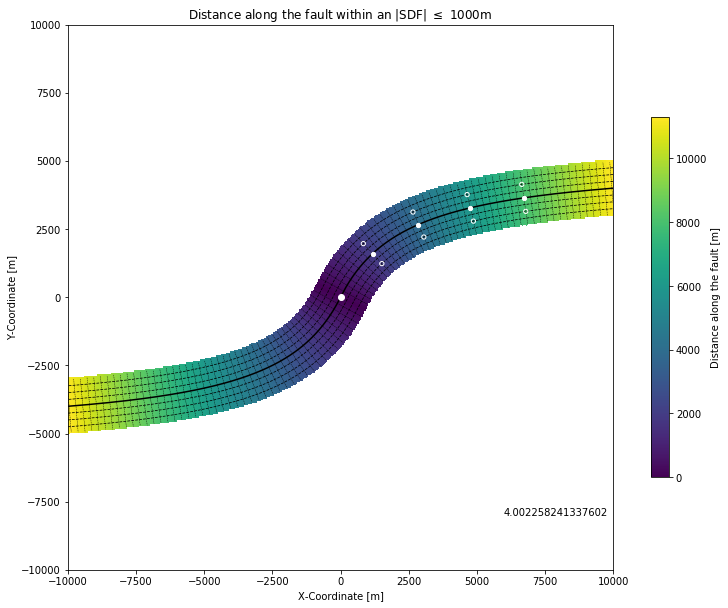

In [257]:
PlotDomain(LCoorX, LCoorY, DistSDFMaskedOut, 
           ["Distance along the fault within an |SDF| $\leq$ 1000m", "Distance along the fault [m]"],
           TimeStepVal)
plt.plot(xx,func(xx),"k-")
plt.contour(LCoorX,LCoorY,DistSDFMaskedOut,levels=np.arange(-1.5e4, 1.5e4, 250), colors="k", linestyles="--",linewidths=0.4)
plt.contour(LCoorX,LCoorY,OnlyDistMaskedOut,levels=np.arange(-1.e3, 1.e3, 250), colors="k", linestyles="--",linewidths=0.75)


MarkerSpecs = {"marker":".","c":"w","s":72,"zorder":9}
plt.scatter(0, 0, c="w", zorder=9)
plt.scatter(xx[idx_Interest],func(xx[idx_Interest]), **MarkerSpecs)

MarkerSpecs = {"marker":".","facecolors":"none","edgecolors":"w","s":72,"zorder":9}
plt.scatter(CoordinatesList[0],CoordinatesList[1], **MarkerSpecs)
plt.scatter(TwinCoordinatesList[0],TwinCoordinatesList[1], **MarkerSpecs)

### In this case, we have the object FirstPoint, which contains the coordinate pairs of the receiver of interest on the positive and negative side of the fault.

What we need to have now is to feed displacement and velocity fields to each of the elements on the list of FaultDataObj

In [269]:
def PopulateListFaultDataObj_w_Fields(ListFaultDataObj, w_filename, se2_coor):
    TimeStep, SplineDisplPair, SplineVelPair = GetSplineFunctions(w_filename, se2_coor)
    
    for FaultDataObj in ListFaultDataObj:
        Slip = FaultDataObj.ExtractTangentFieldComponentDiff(SplineDisplPair)
        SlipRate = FaultDataObj.ExtractTangentFieldComponentDiff(SplineVelPair)
        
        FaultDataObj.appendFaultValues(TimeStep, Slip, SlipRate)
        
    return ListFaultDataObj

In [270]:
LocOfInterest = [2000,4000,6000,8000]
Thickness = 500


fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/se2wave/"


i=1131
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

ListFaultDataObj = Init_ListFaultDataObj(Thickness, LocOfInterest, xx, func(xx), func_der(xx))

ListFaultDataObj = PopulateListFaultDataObj_w_Fields(ListFaultDataObj, FieldFilename, se2_coor)

In [279]:
ListFaultDataObj[-1].SlipRate

[0.2443379550001723]